# Tutorial: ProjectionAnalysisVisualizer
*A step-by-step guide to analyze and visualize projections*

---

## Introduction

The `ProjectionAnalysisVisualizer` is the main engine of the library. It lets you compute projections, triangulations, distortion metrics, and inverse models. You can also use its internal utilities separately for fine-grained control.

* It can be used for both *Supervised learning* and *Unsupervised learning* tasks.
* Three main components:

  * **ProjectionAnalysisVisualizer** (analysis engine).
  * **Visualizer utilities** (plotting functions).
  * **tools utilities** (interactive tool).
* Flexible: call methods from the class, or use utilities directly.

Import the main class as follows:

```python
from projection_framework import ProjectionAnalysisVisualizer, visualizer, tools
```

---


 With these imports, you have access to the **analysis framework**, **visualization utilities**, and **datasets**, enabling a complete workflow from data loading to projection analysis.

---

# Import required packages

In [3]:
from projection_framework import ProjectionAnalysisVisualizer, visualizer, tools
from datasets.datasets import *
import projection_framework
# from sklearn import manifold


In [4]:
projection_framework.__version__

'0.1.0.dev5'


---

# Dataset Usage

This package supports both **real-world datasets** and a set of **synthetic datasets** specifically designed for testing and benchmarking supervised or unsupervised learning tasks.

## Synthetic Datasets

We provide four synthetic dataset configurations, each based on Gaussian distributions arranged with different spatial relationships:

* **`tetrahedron_eq`**
  All four Gaussians are placed equidistant from each other, forming a balanced tetrahedral structure.

* **`tetrahedron_eq_1_far`**
  One Gaussian is positioned farther away but equidistant from the remaining three, while the three closer Gaussians are equidistant among themselves.

* **`tetrahedron_eq_1_close`**
  One Gaussian is positioned closer to the group, equidistant from the other three. The three remaining Gaussians are also equidistant among themselves, but farther away from the closer one.

* **`tetrahedron_eq_2_close`**
  Two Gaussians are positioned closer together, while the other two are also closer to each other, forming two equidistant subgroups.

---

These datasets allow controlled experimentation with different cluster configurations, enabling robust evaluation of learning algorithms under varying structural complexities.

---



In [5]:
dataset = 'tetrahedron_eq'
num_dim = 3
n_pts_per_gauss = 200
method = 'tsne'
np.random.seed(5)

In [6]:
D,c, dim, output_size, n_gauss = selected_dataset_dt(dataset, num_dim, n_pts_per_gauss, cluster_spacing = 1.0, spread_factor = 0.01)
class_label = c.astype(int)


---

# Saving Results

To organize experiment outputs, results are stored automatically in structured directories.

```python
output_folder = f"results/{dataset}/{method}_plots"
os.makedirs(output_folder, exist_ok=True)
```

### Explanation

* **`output_folder`**
  Dynamically creates a folder path based on the chosen dataset (`{dataset}`) and projection method (`{method}`), ensuring results remain organized and easy to navigate.

* **`os.makedirs(..., exist_ok=True)`**
  Creates the directory if it does not already exist. The `exist_ok=True` flag prevents errors when the folder is already present, making the workflow seamless and reproducible.

---

###  Directory Structure

When running experiments on different datasets and methods, results are stored in a hierarchical format:

```
results/
├── tetrahedron_eq/
│   ├── PCA_plots/
│   │   ├── projection.png
│   │   ├── metrics.json
│   ├── tSNE_plots/
│   │   ├── projection.png
│   │   ├── metrics.json
│   └── UMAP_plots/
│       ├── projection.png
│       ├── metrics.json
│
├── tetrahedron_eq_1_far/
│   ├── PCA_plots/
│   ├── tSNE_plots/
│   └── UMAP_plots/
│
└── real_dataset/
    ├── PCA_plots/
    ├── tSNE_plots/
    └── UMAP_plots/
```

---

With this structure, each dataset has its own folder, and within it, each projection method has a dedicated subfolder containing plots, metrics, or other outputs. This makes it easy to **compare methods across datasets** or **track experiments over time**.

---


In [7]:
output_folder = f"results/{dataset}/{method}_plots"
os.makedirs(output_folder, exist_ok=True)

# Initializing the framework

To initialize, you need:

* `data` → high-dimensional dataset, **Required**.
* `embedding` → optional, if you already computed it; otherwise specify `projection_method`.
* `class_label` (optional, for supervised visualizations).
* `projection_method` → optional, 'tsne', 'umap'. if embedding **not** given.
* `output_path` (optional, if provided all plots/results are saved in that path).

Raises

        ------
        ValueError
            If neither `embedding` nor `projection_method` is provided.

---

Lets initialize the framework using original data and employing *TSNE* as a projection method. However, you can use other projections also.

In [8]:
proj_viz = ProjectionAnalysisVisualizer(data = D, projection_method= method, class_label= class_label)  # Supervised

## Getting the Low-Dimensional Embedding
* Retrieves the 2D embedding (computed internally or provided).

In [9]:
low_dm_emb = proj_viz.projection_emb_low_dim()

Plot the projection using *visualizer* utility

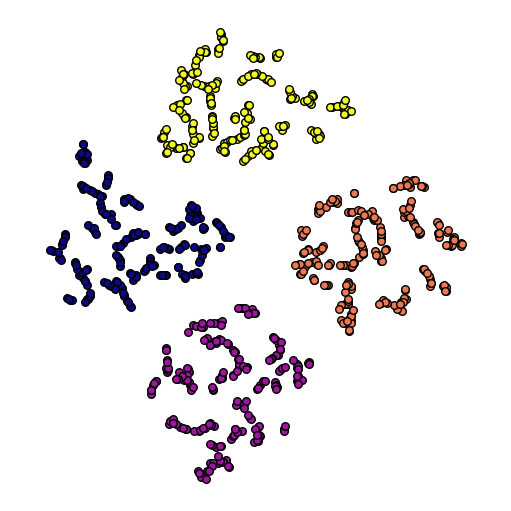

In [10]:
visualizer.plot_projection(embedding=low_dm_emb, class_label = class_label, figsize= (5,5)) 

## Delaunay Triangulation
* Triangulates the embedding space for later interpolation.
* Visualization shows how points are connected.

In [11]:
tri_delaunay = proj_viz.delaunay_triangulation(embedding= low_dm_emb)

Plot Delaunay Triangulation using visualizer utility.

Output folder not specified. Results not saved.


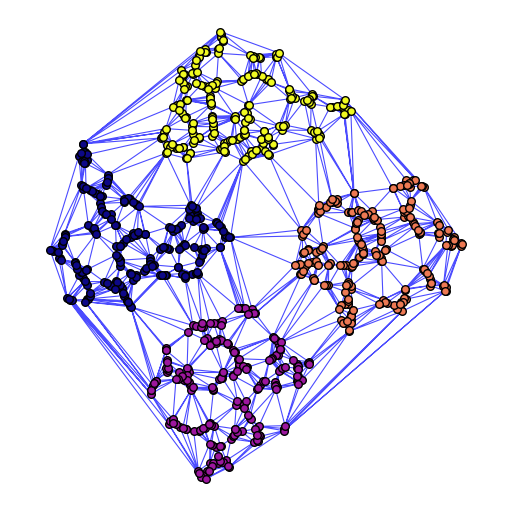

In [12]:
visualizer.plot_delaunay_triangulation(tri_delaunay=tri_delaunay,embedding= low_dm_emb, class_label = class_label, figsize=(5,5))

## Distortion Metrics: NLM & CCA
* **NLM (Normalized Local Metric)**: measures local distortion.
* **CCA (Class Consistency Agreement)**: measures how well class structure is preserved.

You can use any other pair of distortion measure metrics (other that NLM and CCA). e.g. *Trustworthiness* and *Continuity* and plot them. Depends which measure you want to analyze.

In [13]:
nlm, cca, = proj_viz.compute_distortion_prob(D, low_dm_emb) 

Using *visualizer* utility plot the  vornoi diagram using **CheckVIZ paper Implementation**

- Splits space into Voronoi regions and then colored them by distortion metrics intensity value on that point.

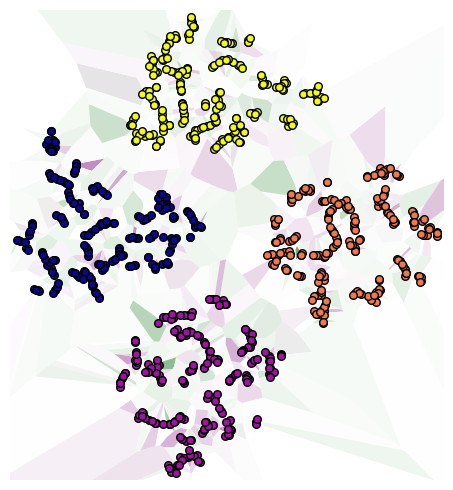

In [27]:
visualizer.plot_vornoi_original(low_dm_emb,cca,nlm, class_label=class_label, figsize=(5,5)) 

# Post Shading
 Interpolates distortions across grid → smooth coloring.
 - Computer probabilites e.g. nlm, cca
 - Apply Barycenteric Interplation on two metrics
 - Compute grid colors using checkViz impelmntaiton: safe_checkviz_map(P_CCA_interp[i, j], P_NLM_interp[i, j])
 

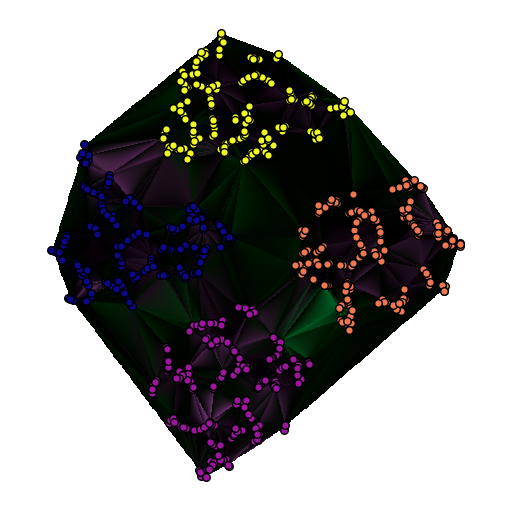

In [28]:
intensity_per_grid = proj_viz.postshading(data = D, embedding= low_dm_emb)

visualizer.plot_analysis(
            low_dm_emb, class_label, intensity_per_grid, bscatter_plot=True, figsize = (5,5)

        )



# Pre Shading
Colors points first, then interpolates.
 - Computer probabilites e.g. CCA, NLM
 - Maps two probability scores (CCA and NLM) to a unique color using the CheckViz colormap
 - Apply Barycentric Interpolation for each RGB channel and then stack channels to create a final plot

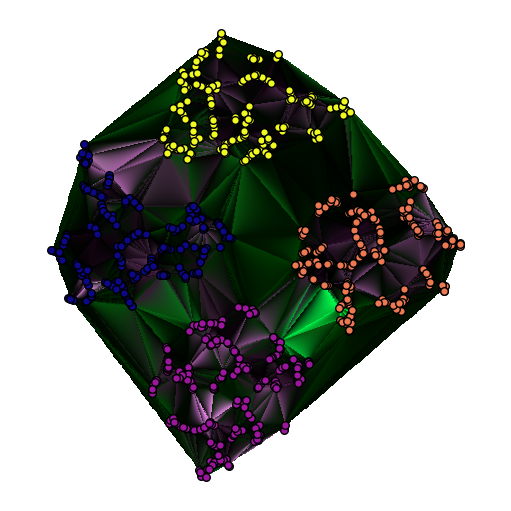

In [29]:
intensity_per_grid_pre = proj_viz.preshading(data = D, embedding= low_dm_emb)

visualizer.plot_analysis(
            low_dm_emb, class_label, intensity_per_grid_pre, bscatter_plot=True, figsize = (5,5)

        )

# Projection Distortions using Delanuany Triangulation

- Interpolate high-dimensional Delaunay edge lengths

In [17]:
intensity_interp_cordinates = proj_viz.delanay_hd_edge_lenghts_inter()

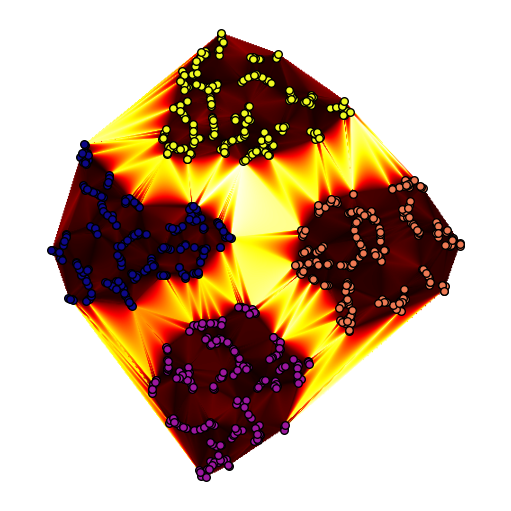

In [30]:
visualizer.plot_analysis(
            low_dm_emb, class_label, intensity_interp_cordinates, bscatter_plot=True, figsize = (5,5)

        )

## Jacobian Spectral Norm Analysis
* Train a neural net to approximate the **inverse projection** (2D → HD).
* Compute **Jacobian spectral norm** to assess stability.

#### Inverse Projection Model



In [19]:
inverse_model, loss = proj_viz.train_inverse_model(input_size = 2, output_size = D.shape[1], num_epochs = 500, batch_size = 64)

Training inverse model ...
Early stopping triggered.
Training complete.
Best Epoch 115
Model not saved. Output folder is not specified.
Model saved to None
Inverse Model Test Loss: 0.0001


c:\Users\waqar\AppData\Local\pypoetry\Cache\virtualenvs\projection-framework-testing-1sMQ1H52-py3.12\Lib\site-packages\projection_framework\visualizer.py:2382: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


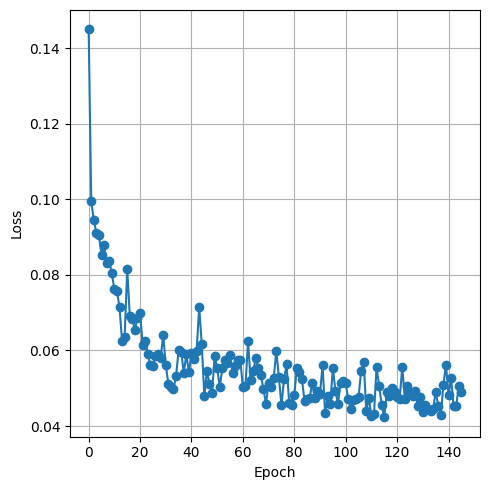

In [20]:
visualizer.plot_training_loss(loss, figsize=(5,5))

Jacobian Spectral Norm calcualtion

In [21]:
jacob, jacob_log = proj_viz.jacobian_spect_norm(low_dm_emb,
                                                      inverse_model,
                                                    # input_size=input_size,
                                                    # output_size=D.shape[1],

                                                    #   output_path = output_folder
                                                      )

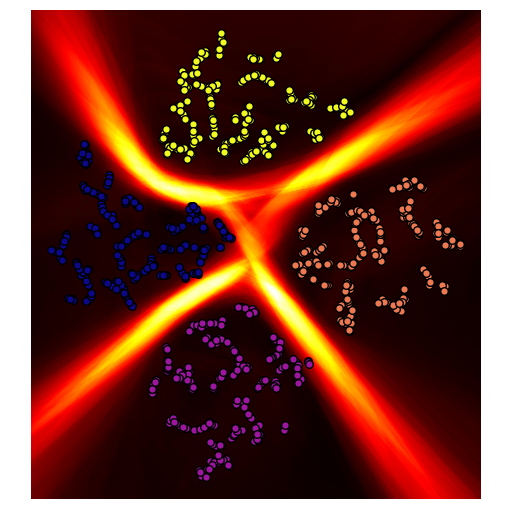

In [31]:
visualizer.plot_analysis(
            low_dm_emb, class_label, jacob, bscatter_plot=True, figsize = (5,5)

        )

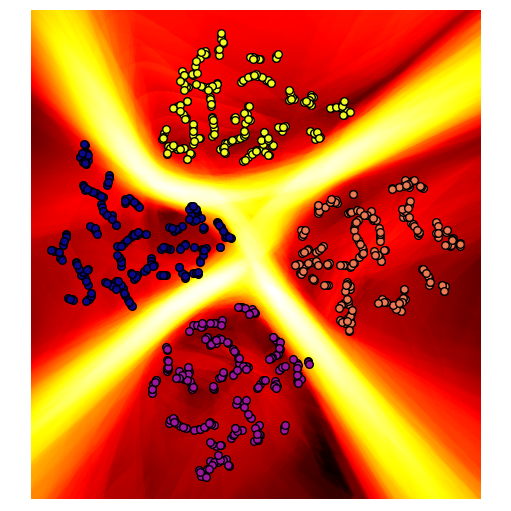

In [32]:
visualizer.plot_analysis(
            low_dm_emb, class_label, jacob_log, bscatter_plot=True, figsize = (5,5)

        )

# Delaunay-Inverse Consistency

- Compute difference between Reconstructed high dimensional data from Delanuay based barycentric coordinate interpolation and inverse model.

In [24]:
difference_delaunay_invserse_proj = proj_viz.difference_delaunay_invserse_proj(low_dm_emb,
                                                    inverse_model,
                                                    # input_size=input_size,
                                                    # output_size=D.shape[1],

                                                    # output_path = output_folder
                                                      )

Barcentirc Coordinate Interpolation starts ...
barycentric coordinates calculation ...
model inference
intensity_per_point calculation ...
Convert Each point in traingle into  color array


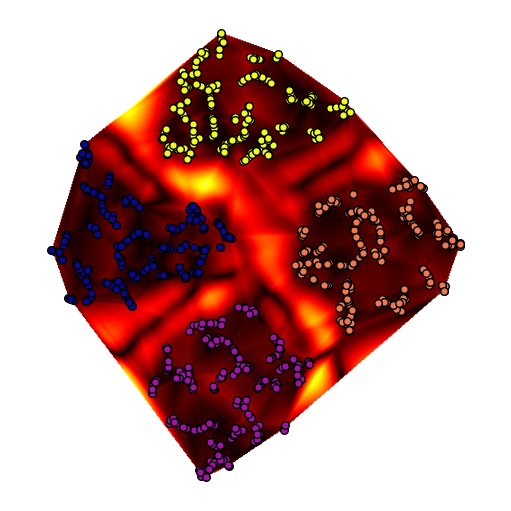

In [33]:
visualizer.plot_analysis(
            low_dm_emb, class_label, difference_delaunay_invserse_proj, bscatter_plot=True, figsize = (5,5)

        )

# Interactive tool

In [26]:
tools.run_interactive_tool(D)

Training inverse model ...
Early stopping triggered.
Training complete.
Best Epoch 58
Model not saved. Output folder is not specified.
Model saved to None
Inverse Model Test Loss: 0.0001
